In [1]:
import os
import numpy as np 
import pandas as pd 
from glob import glob
import json

from merf import MERF
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor

from merf.viz import plot_merf_training_stats
from sklearn.inspection import plot_partial_dependence
# import shap
import math

import seaborn as sns
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

In [2]:
def _get_Z_matrix(Z_values=np.array, Z_vars=list):
    '''
        calculate Z matrix from input variables and selected random effects
    '''
    for i in range(len(Z_vars)):
        Z_vars_array = Z_values[Z_vars[i]].unique()
        if i == 0:
            # Z_vars_array = Z_values[Z_vars[i]].unique()
            Z_df = pd.DataFrame(data=0, columns=Z_vars_array, index=Z_values.index)
        # else:
            # Z_vars_array = np.append(Z_vars_array, Z_values[Z_vars[i]].unique())
        for col in Z_vars_array:
            Z_df[col] = np.where(Z_values[Z_vars[i]] == col, 1, 0)

    return(Z_df)

In [8]:
def get_merf_model(train, Z_vars:list=['SEASON', 'HUC04'], clusters:str='HUC08'):

    rf_fe_b = RandomForestRegressor(n_estimators = 1000, random_state = 42)

    mrf = MERF(rf_fe_b, max_iterations=10)
    X_train = train[['PRECIP', 'MAX_TMP', 'PR_AG', 'PR_INT', 'PR_NAT']]
    clusters_train = train[clusters]
    y_train = train['LOG_PR_WATER']

    if Z_vars is None:
        Z_train = np.ones((len(X_train), 1))
    else:
        Z_values = train[Z_vars]
        Z_train = _get_Z_matrix(Z_values, Z_vars)

    mrf.fit(X_train, Z_train, clusters_train, y_train)

    return(mrf)

In [64]:
def get_dswe_split():
    dswe = pd.read_csv('../data/all_data_0118_p2.csv', index_col=0)
    # dswe['MAX_TMP'] = dswe['MAX_TMP'] * -1
    # dswe['MIN_TMP'] = dswe['MIN_TMP'] * -1
    # dswe['PRECIP'] = dswe['PRECIP'] * -1
    dswe['HUC_SEASON'] = dswe['HUC08'].astype('str') + '_' + dswe['SEASON']

    # dswe = dswe.rename(columns={"PR_WATER": "LOG_PR_WATER"})
    dswe['LOG_PR_WATER'] = np.log(dswe['PR_WATER'] + 10e-6)

    # center and standardize independent variables
    dswe['MAX_TMP'] = (dswe['MAX_TMP'] - np.mean(dswe['MAX_TMP'])) / np.std(dswe['MAX_TMP'])
    dswe['PRECIP'] = (dswe['PRECIP'] - np.mean(dswe['PRECIP'])) / np.std(dswe['PRECIP'])

    dswe['PR_AG'] = (dswe['PR_AG'] - np.mean(dswe['PR_AG'])) / np.std(dswe['PR_AG'])
    dswe['PR_NAT'] = (dswe['PR_NAT'] - np.mean(dswe['PR_NAT'])) / np.std(dswe['PR_NAT'])
    dswe['PR_INT'] = (dswe['PR_INT'] - np.mean(dswe['PR_INT'])) / np.std(dswe['PR_INT'])

    dswe['HUC04'] = dswe['HUC08'].apply(lambda x: str(x)[0:3].zfill(4))

    train, test = train_test_split(dswe, test_size=0.2, shuffle=True)

    return(train, test, dswe)

In [65]:
dswe = pd.read_csv('../data/all_data_0118_p2.csv', index_col=0)
# dswe['MAX_TMP'] = dswe['MAX_TMP'] * -1
# dswe['MIN_TMP'] = dswe['MIN_TMP'] * -1
# dswe['PRECIP'] = dswe['PRECIP'] * -1
dswe['HUC_SEASON'] = dswe['HUC08'].astype('str') + '_' + dswe['SEASON']

# dswe = dswe.rename(columns={"PR_WATER": "LOG_PR_WATER"})
dswe['LOG_PR_WATER'] = np.log(dswe['PR_WATER'] + 10e-6)

# center and standardize independent variables
dswe['MAX_TMP'] = (dswe['MAX_TMP'] - np.mean(dswe['MAX_TMP'])) / np.std(dswe['MAX_TMP'])
dswe['PRECIP'] = (dswe['PRECIP'] - np.mean(dswe['PRECIP'])) / np.std(dswe['PRECIP'])

dswe['PR_AG'] = (dswe['PR_AG'] - np.mean(dswe['PR_AG'])) / np.std(dswe['PR_AG'])
dswe['PR_NAT'] = (dswe['PR_NAT'] - np.mean(dswe['PR_NAT'])) / np.std(dswe['PR_NAT'])
dswe['PR_INT'] = (dswe['PR_INT'] - np.mean(dswe['PR_INT'])) / np.std(dswe['PR_INT'])

dswe['HUC04'] = dswe['HUC08'].apply(lambda x: str(x)[0:3].zfill(4))

In [5]:
train, test = get_dswe_split()

In [66]:
X_test = test[['PRECIP', 'MAX_TMP', 'PR_AG', 'PR_INT', 'PR_NAT']]
clusters_test = test['HUC08']
y_test = test['LOG_PR_WATER']

X_train = train[['PRECIP', 'MAX_TMP', 'PR_AG', 'PR_INT', 'PR_NAT']]
clusters_train = train['HUC08']
y_train = train['LOG_PR_WATER']

X_full = dswe[['PRECIP', 'MAX_TMP', 'PR_AG', 'PR_INT', 'PR_NAT']]
clusters_full = dswe['HUC08']
y_full = dswe['LOG_PR_WATER']


### HUC04 and SEASONs

In [9]:
mrf_huc4_seasons = get_merf_model(train=train, Z_vars=['SEASON', 'HUC04'], clusters='HUC08')

INFO     [merf.py:307] Training GLL is -48513.9673446295 at iteration 1.
INFO     [merf.py:307] Training GLL is -73859.9717182374 at iteration 2.
INFO     [merf.py:307] Training GLL is -76667.53289076487 at iteration 3.
INFO     [merf.py:307] Training GLL is -77308.13980618764 at iteration 4.
INFO     [merf.py:307] Training GLL is -77800.32564844814 at iteration 5.
INFO     [merf.py:307] Training GLL is -78325.23185246756 at iteration 6.
INFO     [merf.py:307] Training GLL is -78813.73017845998 at iteration 7.
INFO     [merf.py:307] Training GLL is -79241.74750342646 at iteration 8.
INFO     [merf.py:307] Training GLL is -79745.16230945759 at iteration 9.
INFO     [merf.py:307] Training GLL is -80134.49555627009 at iteration 10.


c:\Users\mdgaines\.conda\envs\dswe\lib\site-packages\merf\viz.py:65: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  model.trained_b.hist(bins=15, ax=ax)


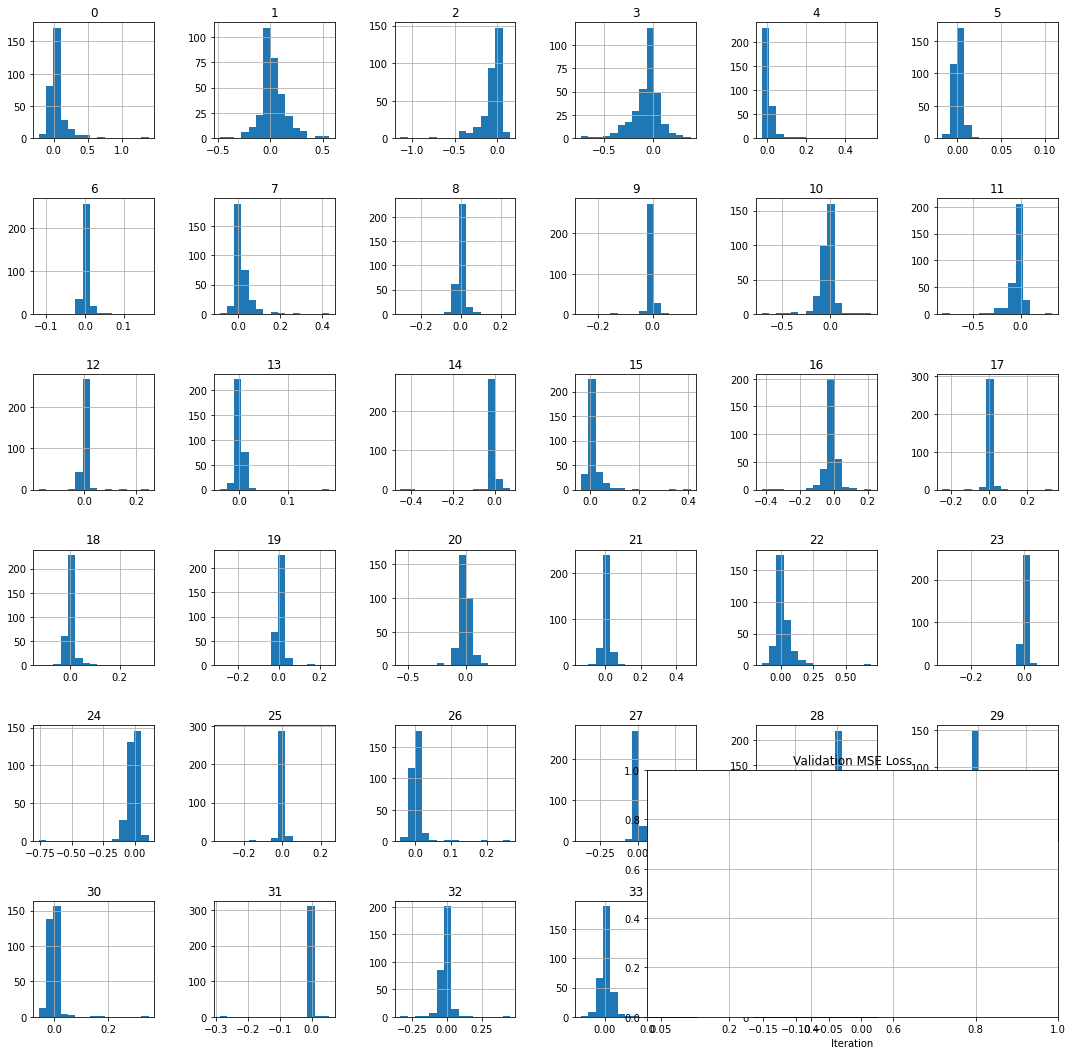

In [10]:
plot_merf_training_stats(mrf_huc4_seasons, num_clusters_to_plot=10)

In [69]:
Z_vars_huc4_seasons = ['SEASON', 'HUC04']
Z_values_huc4_seasons = test[Z_vars_huc4_seasons]
Z_test_huc4_seasons = _get_Z_matrix(Z_values_huc4_seasons, Z_vars_huc4_seasons)

y_hat_huc4_seasons = mrf_huc4_seasons.predict(X_test, Z_test_huc4_seasons, clusters_test)

In [70]:
mse_test_huc4_seasons = np.mean((y_test - y_hat_huc4_seasons) ** 2)
print('MSE:', mse_test_huc4_seasons)

rmspe_test_huc4_seasons = math.sqrt(np.mean( (y_test - y_hat_huc4_seasons) ** 2)) * 100
print('RMSPE:', rmspe_test_huc4_seasons)

mpe_test_huc4_seasons = np.mean(((y_test-y_hat_huc4_seasons) / y_test) * 100)
print('MPE:', mpe_test_huc4_seasons)

r2_test_huc4_seasons = r2_score(y_test, y_hat_huc4_seasons)
print('R2:', r2_test_huc4_seasons)

MSE: 0.16653550116127572
RMSPE: 40.80876145649066
MPE: -1.6071347948591594
R2: 0.9435891223004472


In [72]:
Z_vars_huc4_seasons = ['SEASON', 'HUC04']
Z_values_huc4_seasons = train[Z_vars_huc4_seasons]
Z_train_huc4_seasons = _get_Z_matrix(Z_values_huc4_seasons, Z_vars_huc4_seasons)

y_hat_train_huc4_seasons = mrf_huc4_seasons.predict(X_train, Z_train_huc4_seasons, clusters_train)

mse_train_huc4_seasons = np.mean((y_train - y_hat_train_huc4_seasons) ** 2)
print('MSE:', mse_train_huc4_seasons)

rmspe_train_huc4_seasons = math.sqrt(np.mean( (y_train - y_hat_train_huc4_seasons) ** 2)) * 100
print('RMSPE:', rmspe_train_huc4_seasons)

mpe_train_huc4_seasons = np.mean(((y_train-y_hat_train_huc4_seasons) / y_train) * 100)
print('MPE:', mpe_train_huc4_seasons)

r2_train_huc4_seasons = r2_score(y_train, y_hat_train_huc4_seasons)
print('R2:', r2_train_huc4_seasons)

MSE: 0.0063573636512287545
RMSPE: 7.973307752262391
MPE: -0.15069757784814003
R2: 0.9978448984361983


In [73]:
Z_vars_huc4_seasons = ['SEASON', 'HUC04']
Z_values_huc4_seasons = dswe[Z_vars_huc4_seasons]
Z_full_huc4_seasons = _get_Z_matrix(Z_values_huc4_seasons, Z_vars_huc4_seasons)

y_hat_full_huc4_seasons = mrf_huc4_seasons.predict(X_full, Z_full_huc4_seasons, clusters_full)

In [74]:
mse_full_huc4_seasons = np.mean((y_full - y_hat_full_huc4_seasons) ** 2)
print('MSE:', mse_full_huc4_seasons)

rmspe_full_huc4_seasons = math.sqrt(np.mean( (y_full - y_hat_full_huc4_seasons) ** 2)) * 100
print('RMSPE:', rmspe_full_huc4_seasons)

mpe_full_huc4_seasons = np.mean(((y_full-y_hat_full_huc4_seasons) / y_full) * 100)
print('MPE:', mpe_full_huc4_seasons)

r2_full_huc4_seasons = r2_score(y_full, y_hat_full_huc4_seasons)
print('R2:', r2_full_huc4_seasons)

MSE: 0.09044550108399235
RMSPE: 30.074158522557592
MPE: -1.2591310000096079
R2: 0.9693450898896866


### SEASONS only

In [13]:
mrf_seasons = get_merf_model(train=train, Z_vars=['SEASON'], clusters='HUC08')

INFO     [merf.py:307] Training GLL is -49203.65174852348 at iteration 1.
INFO     [merf.py:307] Training GLL is -74277.71941657495 at iteration 2.
INFO     [merf.py:307] Training GLL is -76532.19288493694 at iteration 3.
INFO     [merf.py:307] Training GLL is -76697.36022609127 at iteration 4.
INFO     [merf.py:307] Training GLL is -76853.53421506009 at iteration 5.
INFO     [merf.py:307] Training GLL is -76939.0944660035 at iteration 6.
INFO     [merf.py:307] Training GLL is -77051.84452042519 at iteration 7.
INFO     [merf.py:307] Training GLL is -77137.97646958844 at iteration 8.
INFO     [merf.py:307] Training GLL is -77256.22001110065 at iteration 9.
INFO     [merf.py:307] Training GLL is -77311.3301955911 at iteration 10.


c:\Users\mdgaines\.conda\envs\dswe\lib\site-packages\merf\viz.py:65: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  model.trained_b.hist(bins=15, ax=ax)
c:\Users\mdgaines\.conda\envs\dswe\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  fig.canvas.print_figure(bytes_io, **kw)


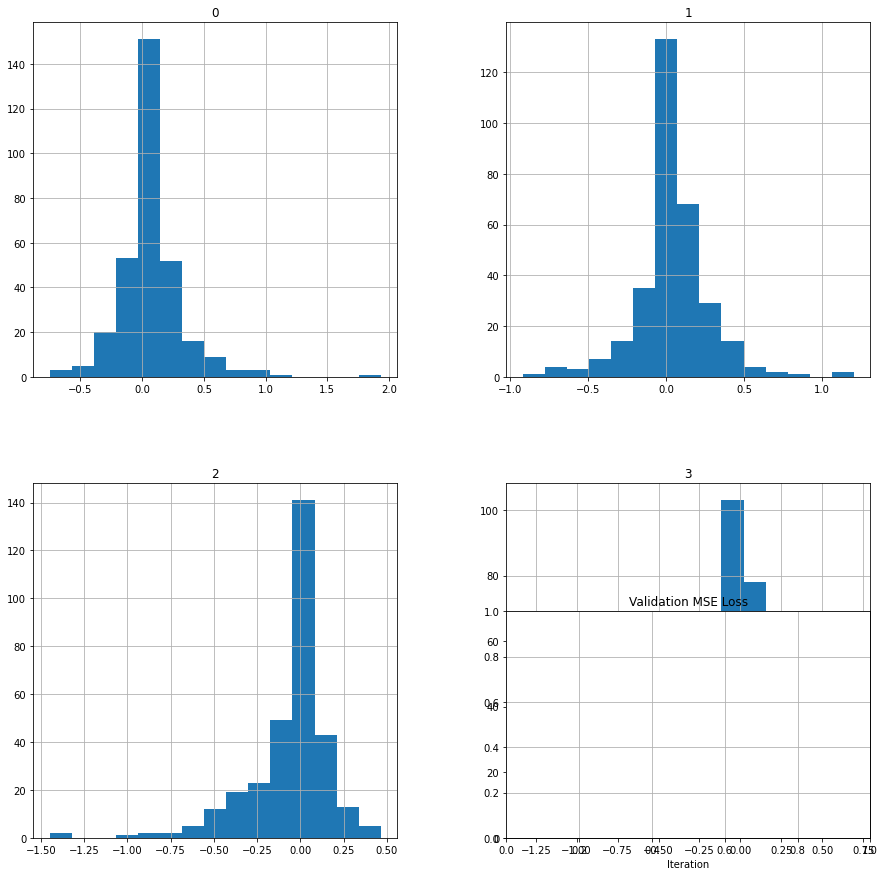

In [14]:
plot_merf_training_stats(mrf_seasons)

In [15]:
Z_vars_seasons = ['SEASON']
Z_values_seasons = test[Z_vars_seasons]
Z_test_seasons = _get_Z_matrix(Z_values_seasons, Z_vars_seasons)

y_hat_seasons = mrf_seasons.predict(X_test, Z_test_seasons, clusters_test)

In [58]:
mse_test_seasons = np.mean((y_test - y_hat_seasons) ** 2)
print('MSE:', mse_test_seasons)

rmspe_test_seasons = math.sqrt(np.mean( (y_test - y_hat_seasons) ** 2)) * 100
print('RMSPE:', rmspe_test_seasons)

mpe_test_seasons = np.mean(((y_test-y_hat_seasons) / y_test) * 100)
print('MPE:', mpe_test_seasons)

r2_test_seasons = r2_score(y_test, y_hat_seasons)
print('R2:', r2_test_seasons)

MSE: 0.11035450803161512
RMSPE: 33.21964900952674
MPE: -0.5498684188398779
R2: 0.9626194138021228


In [76]:
Z_vars_seasons = ['SEASON']
Z_values_seasons = train[Z_vars_seasons]
Z_train_seasons = _get_Z_matrix(Z_values_seasons, Z_vars_seasons)

y_hat_train_seasons = mrf_seasons.predict(X_train, Z_train_seasons, clusters_train)

mse_train_seasons = np.mean((y_train - y_hat_train_seasons) ** 2)
print('MSE:', mse_train_seasons)

rmspe_train_seasons = math.sqrt(np.mean( (y_train - y_hat_train_seasons) ** 2)) * 100
print('RMSPE:', rmspe_train_seasons)

mpe_train_seasons = np.mean(((y_train-y_hat_train_seasons) / y_train) * 100)
print('MPE:', mpe_train_seasons)

r2_train_seasons = r2_score(y_train, y_hat_train_seasons)
print('R2:', r2_train_seasons)

MSE: 0.006397536904264509
RMSPE: 7.998460417020584
MPE: -0.15898671141698728
R2: 0.9978312799859743


In [77]:
Z_vars_seasons = ['SEASON']
Z_values_seasons = dswe[Z_vars_seasons]
Z_full_seasons = _get_Z_matrix(Z_values_seasons, Z_vars_seasons)

y_hat_full_seasons = mrf_seasons.predict(X_full, Z_full_seasons, clusters_full)

mse_full_seasons = np.mean((y_full - y_hat_full_seasons) ** 2)
print('MSE:', mse_full_seasons)

rmspe_full_seasons = math.sqrt(np.mean( (y_full - y_hat_full_seasons) ** 2)) * 100
print('RMSPE:', rmspe_full_seasons)

mpe_full_seasons = np.mean(((y_full-y_hat_full_seasons) / y_full) * 100)
print('MPE:', mpe_full_seasons)

r2_full_seasons = r2_score(y_full, y_hat_full_seasons)
print('R2:', r2_full_seasons)

MSE: 0.04672436511858332
RMSPE: 21.615819465979847
MPE: -0.34055588390065417
R2: 0.9841635991231725


### HUCs only

In [17]:
mrf_hucs = get_merf_model(train=train, Z_vars=None, clusters='HUC08')

INFO     [merf.py:307] Training GLL is -59944.2757745281 at iteration 1.
INFO     [merf.py:307] Training GLL is -66752.23327521556 at iteration 2.
INFO     [merf.py:307] Training GLL is -66856.34154875141 at iteration 3.
INFO     [merf.py:307] Training GLL is -66962.16706377898 at iteration 4.
INFO     [merf.py:307] Training GLL is -67044.07261865486 at iteration 5.
INFO     [merf.py:307] Training GLL is -67134.69230331128 at iteration 6.
INFO     [merf.py:307] Training GLL is -67265.29800029552 at iteration 7.
INFO     [merf.py:307] Training GLL is -67355.83144608412 at iteration 8.
INFO     [merf.py:307] Training GLL is -67478.64191993432 at iteration 9.
INFO     [merf.py:307] Training GLL is -67592.05594933413 at iteration 10.


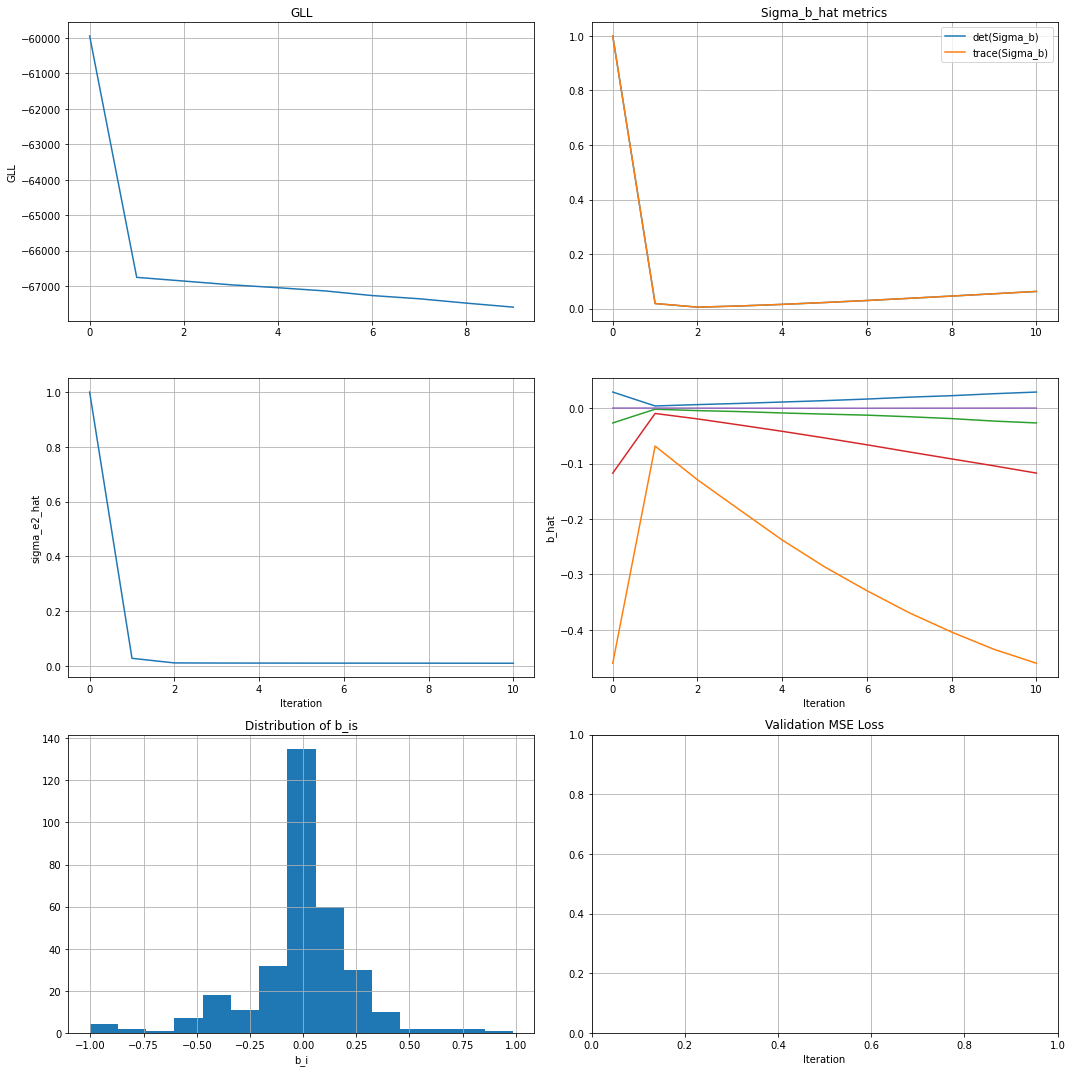

In [18]:
plot_merf_training_stats(mrf_hucs)

In [19]:
# Z_vars_hucs = None
# Z_values_hucs = test[Z_vars_hucs]
# Z_test_hucs = _get_Z_matrix(Z_values_hucs, Z_vars_hucs)
Z_test_hucs = np.ones((len(X_test), 1))

y_hat_hucs = mrf_hucs.predict(X_test, Z_test_hucs, clusters_test)

In [59]:
mse_test_hucs = np.mean((y_test - y_hat_hucs) ** 2)
print('MSE:', mse_test_hucs)

rmspe_test_hucs = math.sqrt(np.mean( (y_test - y_hat_hucs) ** 2)) * 100
print('RMSPE:', rmspe_test_hucs)

mpe_test_hucs = np.mean(((y_test-y_hat_hucs) / y_test) * 100)
print('MPE:', mpe_test_hucs)

r2_test_hucs = r2_score(y_test, y_hat_hucs)
print('R2:', r2_test_hucs)

MSE: 0.0696387957169545
RMSPE: 26.389163631489822
MPE: -0.4751716019719059
R2: 0.9764111221875211


In [78]:
Z_train_hucs = np.ones((len(X_train), 1))

y_hat_train_hucs = mrf_hucs.predict(X_train, Z_train_hucs, clusters_train)

mse_train_hucs = np.mean((y_train - y_hat_train_hucs) ** 2)
print('MSE:', mse_train_hucs)

rmspe_train_hucs = math.sqrt(np.mean( (y_train - y_hat_train_hucs) ** 2)) * 100
print('RMSPE:', rmspe_train_hucs)

mpe_train_hucs = np.mean(((y_train-y_hat_train_hucs) / y_train) * 100)
print('MPE:', mpe_train_hucs)

r2_train_hucs = r2_score(y_train, y_hat_train_hucs)
print('R2:', r2_train_hucs)

MSE: 0.009360273397991566
RMSPE: 9.674850592123667
MPE: -0.212449538882645
R2: 0.9968269331527505


In [79]:
Z_full_hucs = np.ones((len(X_full), 1))

y_hat_full_hucs = mrf_hucs.predict(X_full, Z_full_hucs, clusters_full)

mse_full_hucs = np.mean((y_full - y_hat_full_hucs) ** 2)
print('MSE:', mse_full_hucs)

rmspe_full_hucs = math.sqrt(np.mean( (y_full - y_hat_full_hucs) ** 2)) * 100
print('RMSPE:', rmspe_full_hucs)

mpe_full_hucs = np.mean(((y_full-y_hat_full_hucs) / y_full) * 100)
print('MPE:', mpe_full_hucs)

r2_full_hucs = r2_score(y_full, y_hat_full_hucs)
print('R2:', r2_full_hucs)

MSE: 0.021416506064748736
RMSPE: 14.63437940766493
MPE: -0.26499625365667573
R2: 0.9927412523517098


### HUC08_SEASON Hardcoded

In [21]:
mrf_huc_szn = get_merf_model(train=train, Z_vars=None, clusters='HUC_SEASON')

INFO     [merf.py:307] Training GLL is -49200.247449862334 at iteration 1.
INFO     [merf.py:307] Training GLL is -73834.35044505846 at iteration 2.
INFO     [merf.py:307] Training GLL is -75695.57496798407 at iteration 3.
INFO     [merf.py:307] Training GLL is -75819.96238753876 at iteration 4.
INFO     [merf.py:307] Training GLL is -75907.16729846239 at iteration 5.
INFO     [merf.py:307] Training GLL is -75960.44912415657 at iteration 6.
INFO     [merf.py:307] Training GLL is -75956.72176451168 at iteration 7.
INFO     [merf.py:307] Training GLL is -75966.85979999036 at iteration 8.
INFO     [merf.py:307] Training GLL is -76049.37299363801 at iteration 9.
INFO     [merf.py:307] Training GLL is -76085.28363082188 at iteration 10.


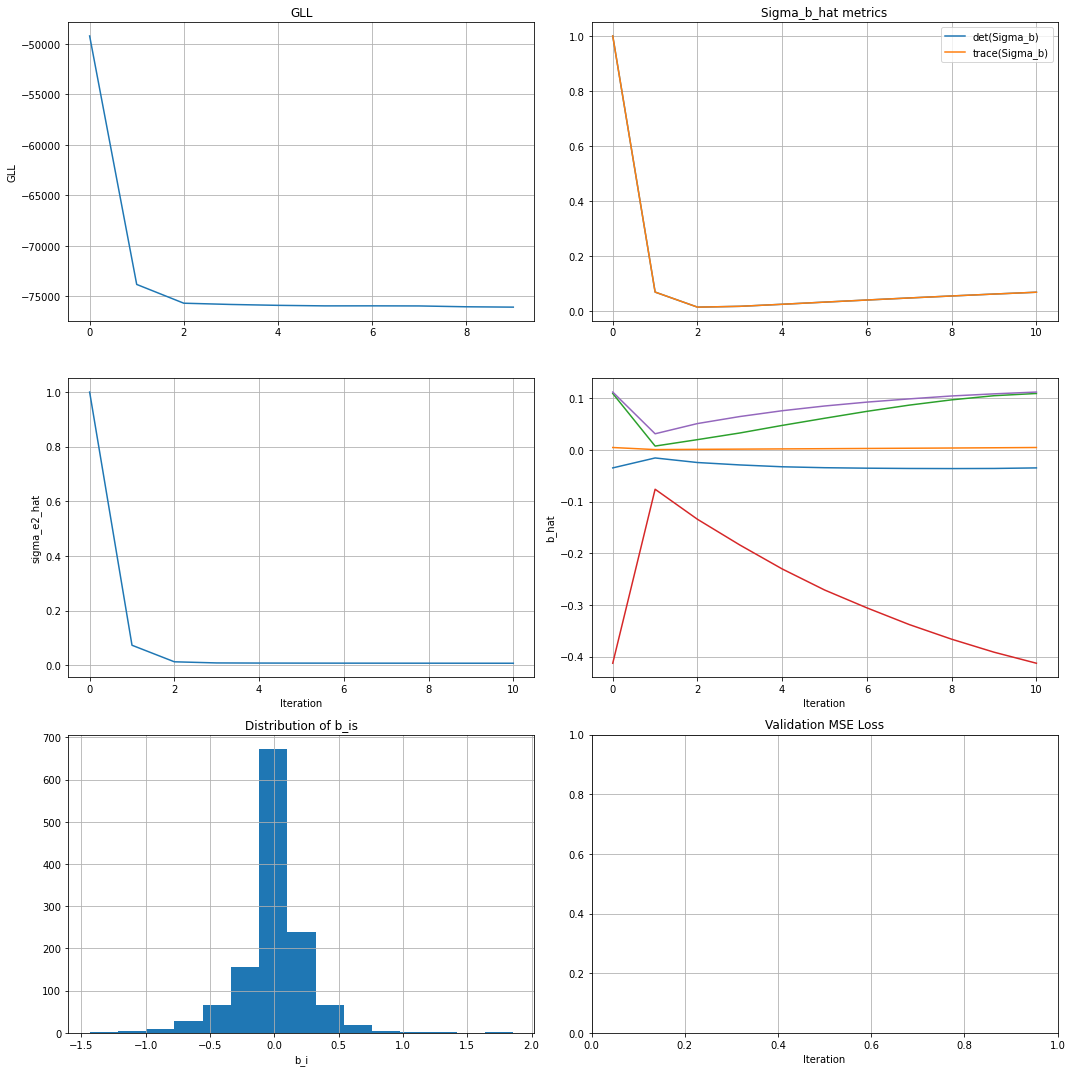

In [22]:
plot_merf_training_stats(mrf_huc_szn)

In [23]:
Z_test_huc_szn = np.ones((len(X_test), 1))

y_hat_huc_szn = mrf_huc_szn.predict(X_test, Z_test_huc_szn, clusters_test)

In [60]:
mse_test_huc_szn = np.mean((y_test - y_hat_huc_szn) ** 2)
print('MSE:', mse_test_huc_szn)

rmspe_test_huc_szn = math.sqrt(np.mean( (y_test - y_hat_huc_szn) ** 2)) * 100
print('RMSPE:', rmspe_test_huc_szn)

mpe_test_huc_szn = np.mean(((y_test-y_hat_huc_szn) / y_test) * 100)
print('MPE:', mpe_test_huc_szn)

r2_test_huc_szn = r2_score(y_test, y_hat_huc_szn)
print('R2:', r2_test_huc_szn)

MSE: 0.13469692038432665
RMSPE: 36.70107905557092
MPE: -1.25738188430838
R2: 0.954373863534669


In [81]:
Z_train_huc_szn = np.ones((len(X_train), 1))

y_hat_train_huc_szn = mrf_huc_szn.predict(X_train, Z_train_huc_szn, clusters_train)

mse_train_huc_szn = np.mean((y_train - y_hat_train_huc_szn) ** 2)
print('MSE:', mse_train_huc_szn)

rmspe_train_huc_szn = math.sqrt(np.mean( (y_train - y_hat_train_huc_szn) ** 2)) * 100
print('RMSPE:', rmspe_train_huc_szn)

mpe_train_huc_szn = np.mean(((y_train-y_hat_train_huc_szn) / y_train) * 100)
print('MPE:', mpe_train_huc_szn)

r2_train_huc_szn = r2_score(y_train, y_hat_train_huc_szn)
print('R2:', r2_train_huc_szn)

MSE: 0.0748486352228765
RMSPE: 27.35847861685231
MPE: -0.9934519600491638
R2: 0.9746268391008172


In [80]:
Z_full_huc_szn = np.ones((len(X_full), 1))

y_hat_full_huc_szn = mrf_huc_szn.predict(X_full, Z_full_huc_szn, clusters_full)

mse_full_huc_szn = np.mean((y_full - y_hat_full_huc_szn) ** 2)
print('MSE:', mse_full_huc_szn)

rmspe_full_huc_szn = math.sqrt(np.mean( (y_full - y_hat_full_huc_szn) ** 2)) * 100
print('RMSPE:', rmspe_full_huc_szn)

mpe_full_huc_szn = np.mean(((y_full-y_hat_full_huc_szn) / y_full) * 100)
print('MPE:', mpe_full_huc_szn)

r2_full_huc_szn = r2_score(y_full, y_hat_full_huc_szn)
print('R2:', r2_full_huc_szn)

MSE: 0.08681881668808943
RMSPE: 29.46503295231306
MPE: -1.046240257641318
R2: 0.9705742907103182


### Plots

In [84]:
test_data = {'Name': ['HUC04 X SEASONS X HUC08', 'SEASONS X HUC08', 'HUC08', 'HUC_SZN'],
        'MSE_TEST': [mse_test_huc4_seasons, mse_test_seasons, mse_test_hucs, mse_test_huc_szn],

        'RMSPE_TEST': [rmspe_test_huc4_seasons, rmspe_test_seasons, rmspe_test_hucs, rmspe_test_huc_szn],
       
        'MPE_TEST': [mpe_test_huc4_seasons, mpe_test_seasons, mpe_test_hucs, mpe_test_huc_szn],
       
        'R2_TEST': [r2_test_huc4_seasons, r2_test_seasons, r2_test_hucs, r2_test_huc_szn],
        }

test_df = pd.DataFrame(test_data)
test_df

,Name,MSE_TEST,RMSPE_TEST,MPE_TEST,R2_TEST
0,HUC04 X SEASONS X HUC08,0.166536,40.808761,-1.607135,0.943589
1,SEASONS X HUC08,0.110355,33.219649,-0.549868,0.962619
2,HUC08,0.069639,26.389164,-0.475172,0.976411
3,HUC_SZN,0.134697,36.701079,-1.257382,0.954374


In [85]:
train_data = {'Name': ['HUC04 X SEASONS X HUC08', 'SEASONS X HUC08', 'HUC08', 'HUC_SZN'],
        'MSE_TRAIN': [mse_train_huc4_seasons, mse_train_seasons, mse_train_hucs, mse_train_huc_szn],
        'RMSPE_TRAIN': [rmspe_train_huc4_seasons, rmspe_train_seasons, rmspe_train_hucs, rmspe_train_huc_szn],
        'MPE_TRAIN': [mpe_train_huc4_seasons, mpe_train_seasons, mpe_train_hucs, mpe_train_huc_szn],
        'R2_TRAIN': [r2_train_huc4_seasons, r2_train_seasons, r2_train_hucs, r2_train_huc_szn],
        }

train_df = pd.DataFrame(train_data)
train_df

,Name,MSE_TRAIN,RMSPE_TRAIN,MPE_TRAIN,R2_TRAIN
0,HUC04 X SEASONS X HUC08,0.006357,7.973308,-0.150698,0.997845
1,SEASONS X HUC08,0.006398,7.998460,-0.158987,0.997831
2,HUC08,0.009360,9.674851,-0.212450,0.996827
3,HUC_SZN,0.074849,27.358479,-0.993452,0.974627


In [86]:
full_data = {'Name': ['HUC04 X SEASONS X HUC08', 'SEASONS X HUC08', 'HUC08', 'HUC_SZN'],
        'MSE_FULL': [mse_full_huc4_seasons, mse_full_seasons, mse_full_hucs, mse_full_huc_szn], 
        'RMSPE_FULL': [rmspe_full_huc4_seasons, rmspe_full_seasons, rmspe_full_hucs, rmspe_full_huc_szn],
        'MPE_FULL': [mpe_full_huc4_seasons, mpe_full_seasons, mpe_full_hucs, mpe_full_huc_szn],
        'R2_FULL': [r2_full_huc4_seasons, r2_full_seasons, r2_full_hucs, r2_full_huc_szn],
        }

full_df = pd.DataFrame(full_data)
full_df

,Name,MSE_FULL,RMSPE_FULL,MPE_FULL,R2_FULL
0,HUC04 X SEASONS X HUC08,0.090446,30.074159,-1.259131,0.969345
1,SEASONS X HUC08,0.046724,21.615819,-0.340556,0.984164
2,HUC08,0.021417,14.634379,-0.264996,0.992741
3,HUC_SZN,0.086819,29.465033,-1.046240,0.970574


In [61]:
print('HUC04 X SEASONS X HUC08')
print('MSE:', mse_test_huc4_seasons)
print('RMSPE:', rmspe_test_huc4_seasons)
print('MPE:', mpe_test_huc4_seasons)
print('R2:', r2_test_huc4_seasons)

print('\nSEASONS X HUC08')
print('MSE:', mse_test_seasons)
print('RMSPE:', rmspe_test_seasons)
print('MPE:', mpe_test_seasons)
print('R2:', r2_test_seasons)

print('\nHUC08')
print('MSE:', mse_test_hucs)
print('RMSPE:', rmspe_test_hucs)
print('MPE:', mpe_test_hucs)
print('R2:', r2_test_hucs)

print('\nHUC08_SEASON')
print('MSE:', mse_test_huc_szn)
print('RMSPE:', rmspe_test_huc_szn)
print('MPE:', mpe_test_huc_szn)
print('R2:', r2_test_huc_szn)

HUC04 X SEASONS X HUC08
MSE: 0.16653550116127572
RMSPE: 40.80876145649066
MPE: -1.6071347948591594
R2: 0.9435891223004472

SEASONS X HUC08
MSE: 0.11035450803161512
RMSPE: 33.21964900952674
MPE: -0.5498684188398779
R2: 0.9626194138021228

HUC08
MSE: 0.0696387957169545
RMSPE: 26.389163631489822
MPE: -0.4751716019719059
R2: 0.9764111221875211

HUC08_SEASON
MSE: 0.13469692038432665
RMSPE: 36.70107905557092
MPE: -1.25738188430838
R2: 0.954373863534669


In [41]:
test['Y_HUC4_SEASON'] = y_hat_huc4_seasons
test['Y_SEASON'] = y_hat_seasons
test['Y_HUC8'] = y_hat_hucs
test['Y_HUC_SZN'] = y_hat_huc_szn


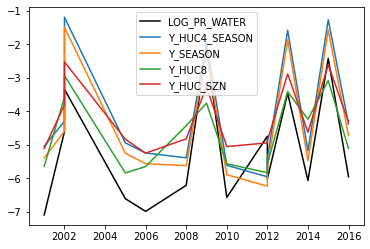

In [44]:
plt.plot('YEAR', 'LOG_PR_WATER', data=test[test['HUC08']==8010206].sort_values('YEAR'), color='black')
plt.plot('YEAR', 'Y_HUC4_SEASON', data=test[test['HUC08']==8010206].sort_values('YEAR'))
plt.plot('YEAR', 'Y_SEASON', data=test[test['HUC08']==8010206].sort_values('YEAR'))
plt.plot('YEAR', 'Y_HUC8', data=test[test['HUC08']==8010206].sort_values('YEAR'))
plt.plot('YEAR', 'Y_HUC_SZN', data=test[test['HUC08']==8010206].sort_values('YEAR'))

plt.legend()

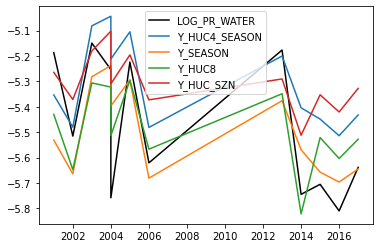

In [47]:
plt.plot('YEAR', 'LOG_PR_WATER', data=test[test['HUC08']==3150202].sort_values('YEAR'), color='black')
plt.plot('YEAR', 'Y_HUC4_SEASON', data=test[test['HUC08']==3150202].sort_values('YEAR'))
plt.plot('YEAR', 'Y_SEASON', data=test[test['HUC08']==3150202].sort_values('YEAR'))
plt.plot('YEAR', 'Y_HUC8', data=test[test['HUC08']==3150202].sort_values('YEAR'))
plt.plot('YEAR', 'Y_HUC_SZN', data=test[test['HUC08']==3150202].sort_values('YEAR'))

plt.legend()

{'bodies': [<matplotlib.collections.PolyCollection at 0x13ed0d17fa0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x13ed0d17ee0>,
 'cmins': <matplotlib.collections.LineCollection at 0x13ed0d41270>,
 'cbars': <matplotlib.collections.LineCollection at 0x13ed0d416c0>}

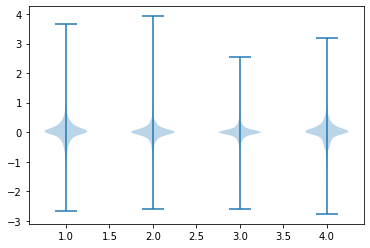

In [54]:
plt.violinplot([y_test - y_hat_huc4_seasons, \
                y_test - y_hat_seasons, \
                y_test - y_hat_hucs,\
                y_test - y_hat_huc_szn])

In [56]:
r2_score(y_test, y_hat_huc4_seasons)

0.9435891223004472